In [4]:
# Cell 1: Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

#  imports for hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score


In [6]:
# Cell 2: Reading Data Set

data = pd.read_csv('cybersecurity_intrusion_data.csv')
data.head()


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [7]:
# Cell 3: Shape of Dataset (Total Rows and Columns)

data.shape


(9537, 11)

In [8]:
# Cell 4: Finding Missing values in the Data set

data.isnull().sum()


,0
session_id,0
network_packet_size,0
protocol_type,0
login_attempts,0
session_duration,0
encryption_used,1966
ip_reputation_score,0
failed_logins,0
browser_type,0
unusual_time_access,0


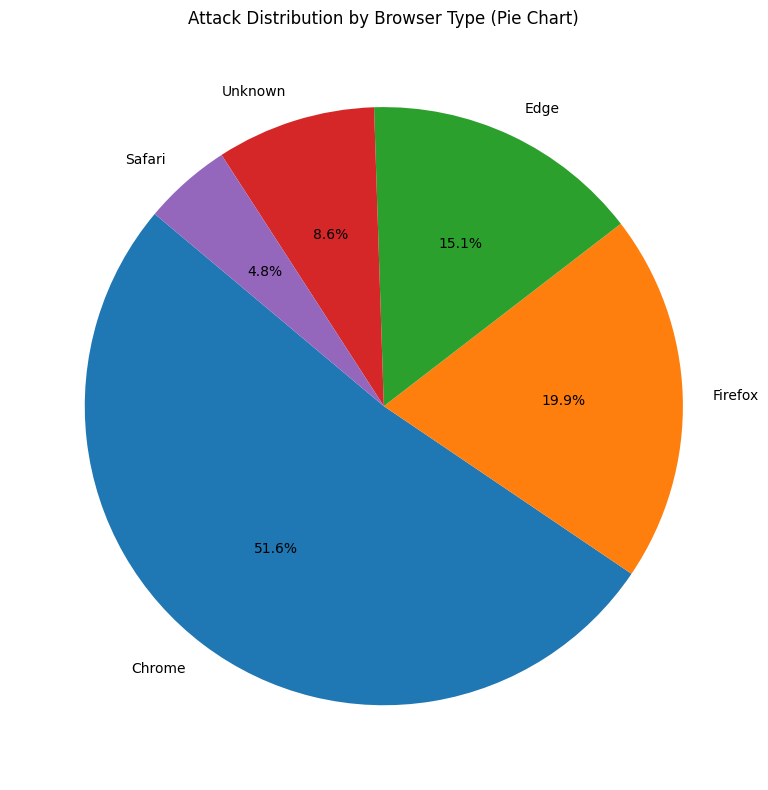

Attack counts by browser:


,browser_type,Attack_Count
0,Chrome,2202
1,Firefox,849
2,Edge,643
3,Unknown,367
4,Safari,203


In [9]:
# Attacks by Browser Type (Pie Chart)

# Count only attacks (attack_detected == 1) per browser
attack_by_browser = (
    data[data['attack_detected'] == 1]
    .groupby('browser_type')
    .size()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 8))
plt.pie(
    attack_by_browser.values,
    labels=attack_by_browser.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Attack Distribution by Browser Type (Pie Chart)')
plt.tight_layout()
plt.show()

print("Attack counts by browser:")
display(attack_by_browser.reset_index(name='Attack_Count'))


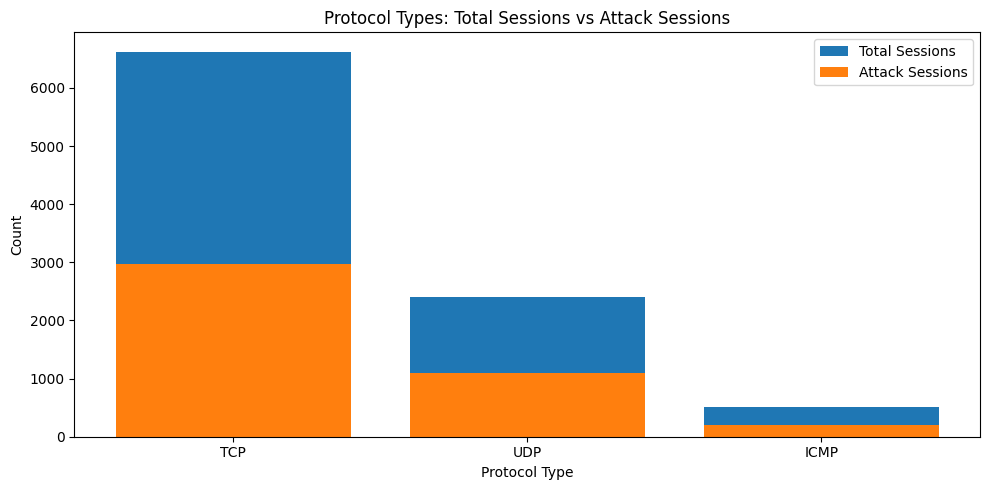

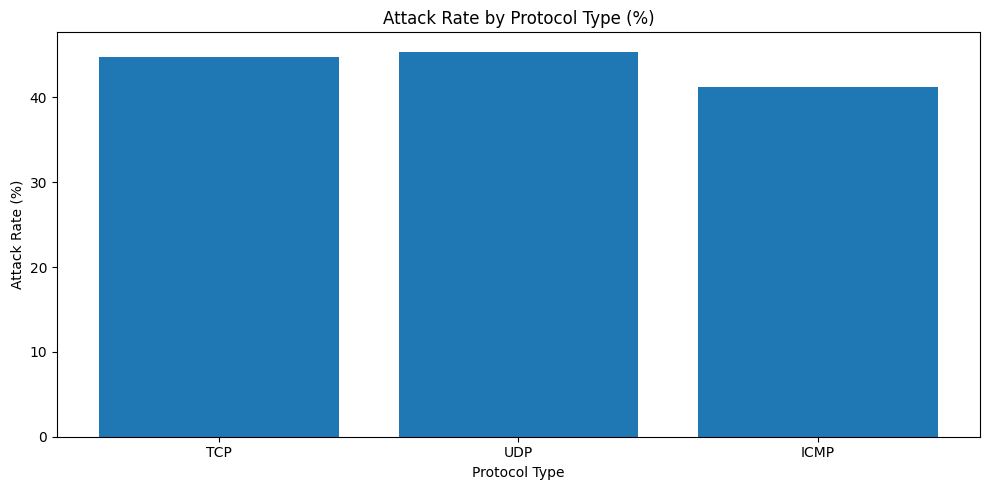

Protocol summary:


,protocol_type,Total_Sessions,Attack_Sessions,Attack_Rate_%
0,TCP,6624,2963,44.731280
1,UDP,2406,1092,45.386534
2,ICMP,507,209,41.222880


In [11]:
#  Protocol Type Analysis (Bar Graph + Attack Rate)
# Total sessions by protocol
total_by_protocol = data['protocol_type'].value_counts()

# Attacks by protocol
attack_by_protocol = data[data['attack_detected'] == 1]['protocol_type'].value_counts()

# Combine into a table
protocol_df = pd.DataFrame({
    'Total_Sessions': total_by_protocol,
    'Attack_Sessions': attack_by_protocol
}).fillna(0)

protocol_df['Attack_Rate_%'] = (protocol_df['Attack_Sessions'] / protocol_df['Total_Sessions']) * 100
protocol_df = protocol_df.sort_values('Total_Sessions', ascending=False)

# Bar chart: total vs attacks
plt.figure(figsize=(10, 5))
plt.bar(protocol_df.index, protocol_df['Total_Sessions'], label='Total Sessions')
plt.bar(protocol_df.index, protocol_df['Attack_Sessions'], label='Attack Sessions')
plt.title('Protocol Types: Total Sessions vs Attack Sessions')
plt.xlabel('Protocol Type')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart: attack rate %
plt.figure(figsize=(10, 5))
plt.bar(protocol_df.index, protocol_df['Attack_Rate_%'])
plt.title('Attack Rate by Protocol Type (%)')
plt.xlabel('Protocol Type')
plt.ylabel('Attack Rate (%)')
plt.tight_layout()
plt.show()

print("Protocol summary:")
display(protocol_df.reset_index().rename(columns={'index': 'protocol_type'}))


In [12]:
# Cell 5: Filling the missing Values with Mode (Most Frequent Value)

for col in ['encryption_used']:
    data[col] = data[col].fillna(data[col].mode()[0])

print(data.isnull().sum())


session_id             0
network_packet_size    0
protocol_type          0
login_attempts         0
session_duration       0
encryption_used        0
ip_reputation_score    0
failed_logins          0
browser_type           0
unusual_time_access    0
attack_detected        0
dtype: int64


In [13]:
# Cell 6: Data Preparing

# remove ID column
data = data.drop('session_id', axis=1)

# one-hot encode categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# features and target
X = data.drop('attack_detected', axis=1)
y = data['attack_detected']

print("Features:", X.columns.tolist())
print("Target labels:", y.unique())
print("Data shape:", data.shape)


Features: ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access', 'protocol_type_TCP', 'protocol_type_UDP', 'encryption_used_DES', 'browser_type_Edge', 'browser_type_Firefox', 'browser_type_Safari', 'browser_type_Unknown']
Target labels: [1 0]
Data shape: (9537, 14)


In [14]:
# Cell 7: Splitting the Data into Train and Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [15]:
# Cell 8: Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)


(7629, 13)
(1908, 13)


In [16]:
# Cell 9: Decision Tree Model

dt = DecisionTreeClassifier(max_depth=2, criterion='gini', random_state=44)
dt.fit(X_train_scaled, y_train)

y_pred_dt = dt.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt) * 100
print(f"Accuracy: {accuracy_dt:.4f}")


Accuracy: 81.4990


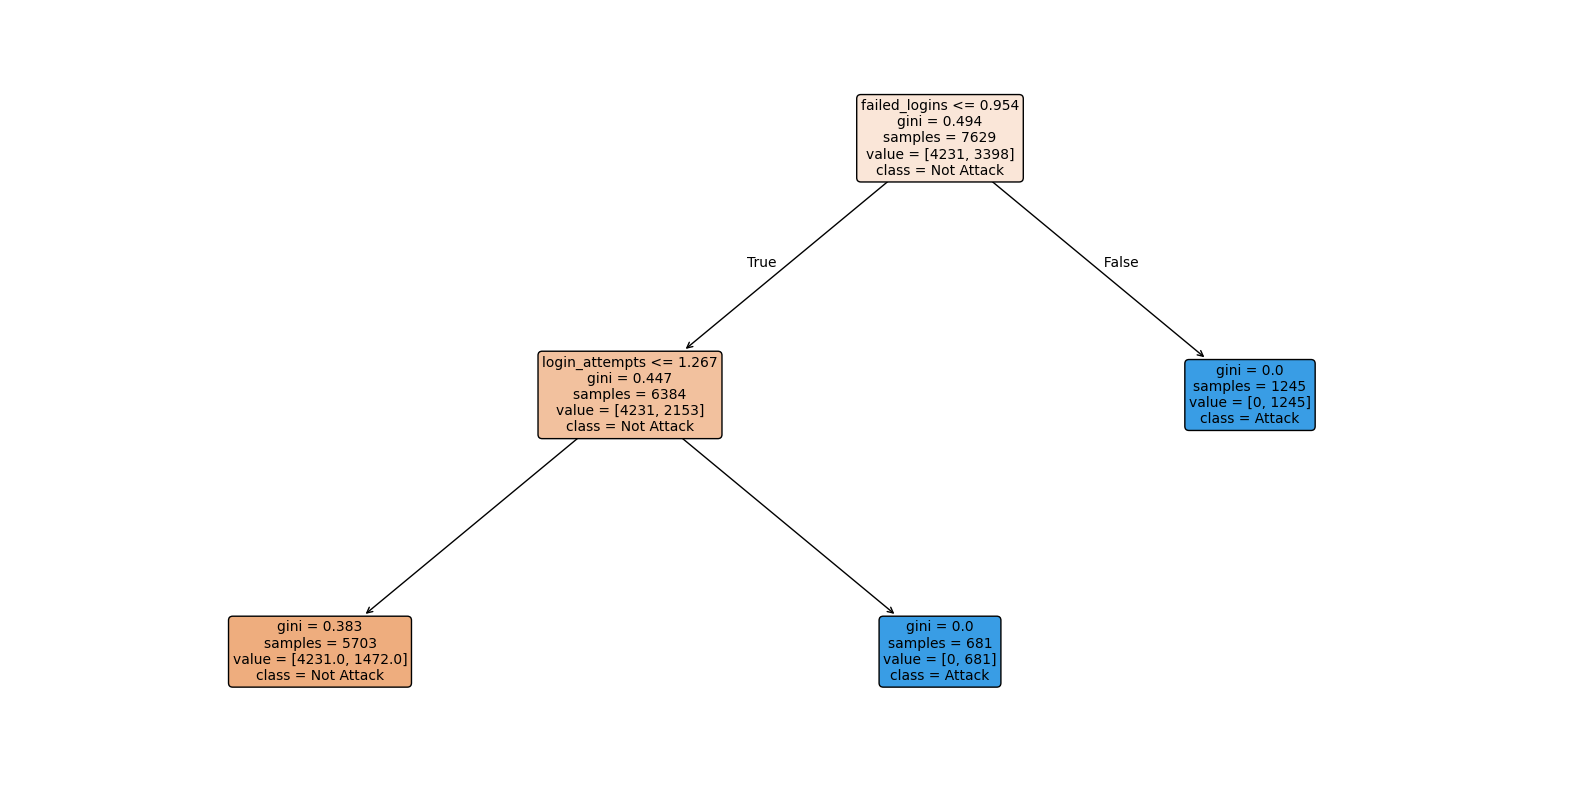

In [17]:
# Cell 10: Decision Tree Plot

plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=X_train.columns,
    class_names=['Not Attack', 'Attack'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()


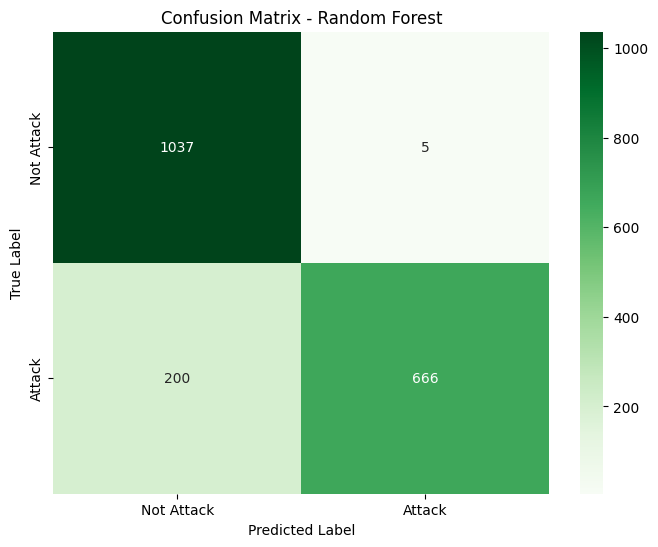

Precision: 99.2548435171386
Recall: 76.905311778291


In [18]:
# Cell 11: Random Forest Model

rf_model = RandomForestClassifier(random_state=44)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Not Attack', 'Attack'],
    yticklabels=['Not Attack', 'Attack']
)
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("Precision:", precision_score(y_test, y_pred_rf) * 100)
print("Recall:", recall_score(y_test, y_pred_rf) * 100)


In [19]:
# Cell 12: Random Forest Summary

print("### Accuracy (approx): The model performs well overall, classifying attacks and non-attacks. ###\n")
print("* Precision (high): When it predicts attack, it is very accurate.")
print("* Recall (lower): Some real attacks are still missed (false negatives).")
print("* Conclusion: Strong model but may miss a portion of true attacks.")


### Accuracy (approx): The model performs well overall, classifying attacks and non-attacks. ###

* Precision (high): When it predicts attack, it is very accurate.
* Recall (lower): Some real attacks are still missed (false negatives).
* Conclusion: Strong model but may miss a portion of true attacks.


In [20]:
# Cell 13: Support Vector Machine Model

clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(X_train_scaled, y_train)

y_pred_svm = clf_svm.predict(X_test_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm) * 100
precision_svm = precision_score(y_test, y_pred_svm) * 100
recall_svm = recall_score(y_test, y_pred_svm) * 100

print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)


Accuracy: 75.20964360587003
Precision: 76.58998646820027
Recall: 65.35796766743648


In [21]:
# Cell 14: SVM Summary

print("###Accuracy: SVM performs well overall.###\n")
print("* Precision: Good, but lower than Random Forest.")
print("* Recall: Misses more actual attacks compared to some models.")
print("* Conclusion: Useful, but trade-off between precision and recall.")


###Accuracy: SVM performs well overall.###

* Precision: Good, but lower than Random Forest.
* Recall: Misses more actual attacks compared to some models.
* Conclusion: Useful, but trade-off between precision and recall.


In [22]:
# Cell 15: K-Nearest Neighbors Model

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn) * 100
precision_knn = precision_score(y_test, y_pred_knn) * 100
recall_knn = recall_score(y_test, y_pred_knn) * 100

print('Model accuracy score: {0:0.4f}'.format(accuracy_knn))
print("Precision :", precision_knn)
print("Recall :", recall_knn)


Model accuracy score: 80.6604
Precision : 90.53833605220228
Recall : 64.08775981524249


In [23]:
# Cell 16: GaussianNB (Gaussian Naive Bayes) model

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

y_pred_gnb = gnb.predict(X_test_scaled)

accuracy_gnb = accuracy_score(y_test, y_pred_gnb) * 100
precision_gnb = precision_score(y_test, y_pred_gnb) * 100
recall_gnb = recall_score(y_test, y_pred_gnb) * 100

print('Model accuracy score: {0:0.4f}'.format(accuracy_gnb / 100))
print("Accuracy:", accuracy_gnb)
print("Precision:", precision_gnb)
print("Recall:", recall_gnb)


Model accuracy score: 0.8265
Accuracy: 82.65199161425576
Precision: 89.98505231689087
Recall: 69.5150115473441


In [24]:
# Cell 17: Training vs Test score for KNN

print('Training set score: {:.4f}'.format(knn.score(X_train_scaled, y_train) * 100))
print('Test set score: {:.4f}'.format(knn.score(X_test_scaled, y_test) * 100))


Training set score: 84.4672
Test set score: 80.6604


In [25]:
# Cell 18: Model Comparison - Define models (based on models used above)

models = {
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=2, criterion='gini', random_state=44),
    "Random Forest Classifier": RandomForestClassifier(random_state=44),
    "Support Vector Machine": svm.SVC(kernel='linear'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=9),
    "Naive Bayes Classifier": GaussianNB()
}


In [26]:
# Cell 19: Evaluate all models and store metrics

metrics_comp = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred) * 100
    pre = precision_score(y_test, y_pred) * 100
    rec = recall_score(y_test, y_pred) * 100
    f1  = f1_score(y_test, y_pred) * 100

    metrics_comp['Model'].append(name)
    metrics_comp['Accuracy'].append(acc)
    metrics_comp['Precision'].append(pre)
    metrics_comp['Recall'].append(rec)
    metrics_comp['F1'].append(f1)

    print(f"Model: {name}")
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {pre:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Recall: {rec:.2f}")
    print("-" * 30)


metrics_df = pd.DataFrame(metrics_comp)
display(metrics_df)


Model: Decision Tree Classifier
Accuracy: 81.50
Precision: 100.00
F1 Score: 74.40
Recall: 59.24
------------------------------
Model: Random Forest Classifier
Accuracy: 89.26
Precision: 99.25
F1 Score: 86.66
Recall: 76.91
------------------------------
Model: Support Vector Machine
Accuracy: 75.21
Precision: 76.59
F1 Score: 70.53
Recall: 65.36
------------------------------
Model: K-Nearest Neighbors
Accuracy: 80.66
Precision: 90.54
F1 Score: 75.05
Recall: 64.09
------------------------------
Model: Naive Bayes Classifier
Accuracy: 82.65
Precision: 89.99
F1 Score: 78.44
Recall: 69.52
------------------------------


,Model,Accuracy,Precision,Recall,F1
0,Decision Tree Classifier,81.498952,100.000000,59.237875,74.401740
1,Random Forest Classifier,89.255765,99.254844,76.905312,86.662329
2,Support Vector Machine,75.209644,76.589986,65.357968,70.529595
3,K-Nearest Neighbors,80.660377,90.538336,64.087760,75.050710
4,Naive Bayes Classifier,82.651992,89.985052,69.515012,78.436482


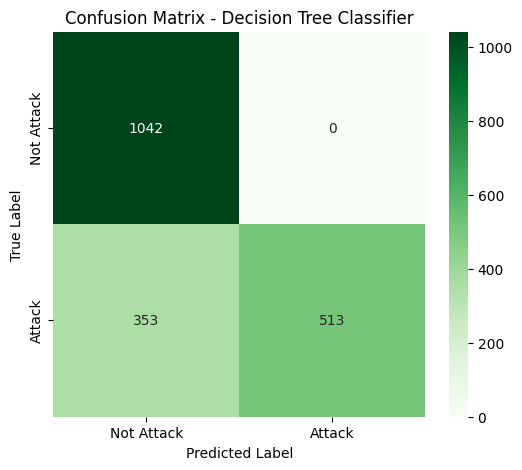

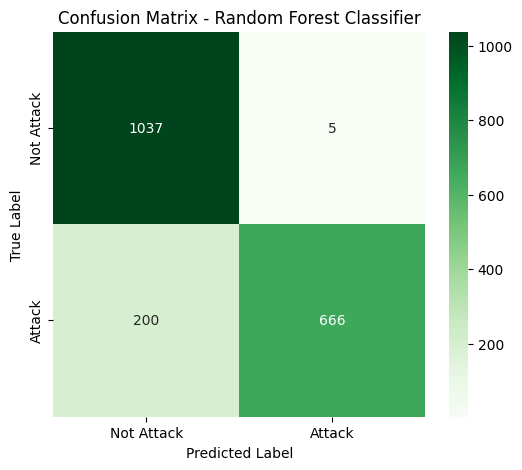

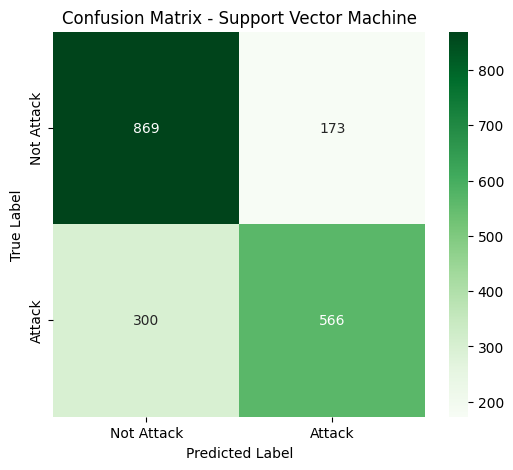

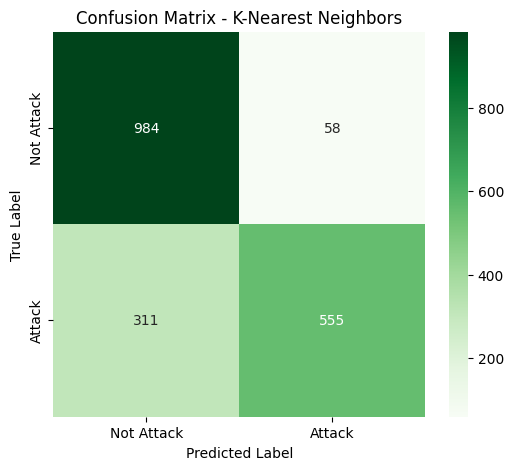

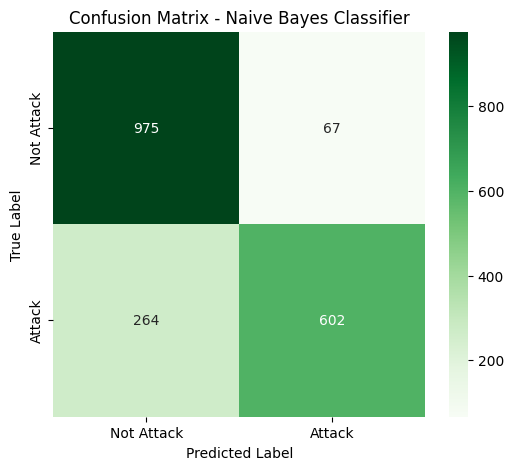

In [27]:
# Cell 20: Confusion Matrix for each model

accuracy_results = {}
classes = np.unique(y_test)

for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results[name] = accuracy

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=['Not Attack', 'Attack'],
        yticklabels=['Not Attack', 'Attack']
    )
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


<Figure size 1400x600 with 0 Axes>

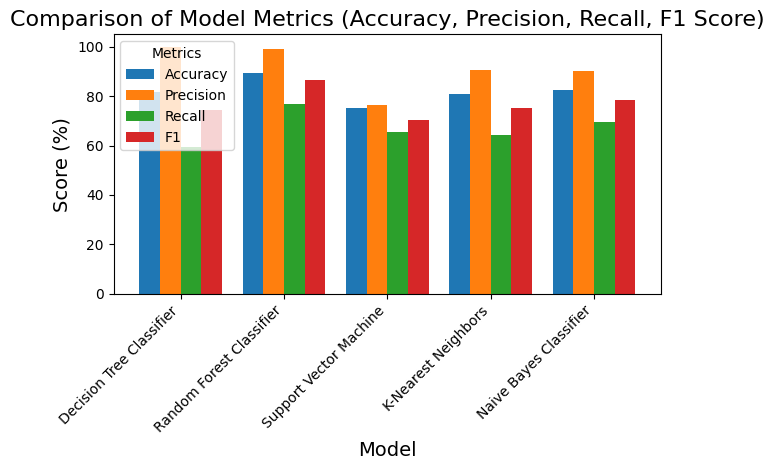

In [28]:
# Cell 21: Comparison Bar Chart (Accuracy, Precision, Recall)

metrics_df = pd.DataFrame(metrics_comp)

plt.figure(figsize=(14, 6))
metrics_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1']].plot(
    kind='bar',
    width=0.8
)
plt.title('Comparison of Model Metrics (Accuracy, Precision, Recall, F1 Score)', fontsize=16)
plt.ylabel('Score (%)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics', loc='upper left')
plt.tight_layout()
plt.show()



In [29]:
# Cell 22: Class balance check

print("Class distribution (y):")
print(
    y.value_counts(normalize=True)
      .rename({0: "Not Attack", 1: "Attack"})
      .map(lambda v: f"{v:.2%}")
)


Class distribution (y):
attack_detected
Not Attack    55.29%
Attack        44.71%
Name: proportion, dtype: object


In [30]:
# Cell 23  CV, Pipelines, and Param Grids


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = {'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'accuracy': 'accuracy'}

# Pipelines with scaling inside where useful
pipe_dt = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', DecisionTreeClassifier(random_state=44))
])

pipe_rf = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', RandomForestClassifier(random_state=44, n_jobs=-1))
])

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', svm.SVC(random_state=44, probability=True))
])

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

pipe_gnb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GaussianNB())
])



param_grid_dt = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 3, 6, 10],
    'clf__min_samples_split': [2, 10],
    'clf__min_samples_leaf': [1, 4],
    'clf__class_weight': [None, 'balanced']
}

param_grid_rf = {
    'clf__n_estimators': [200, 400, 600],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 0.5],
    'clf__bootstrap': [True],
    'clf__class_weight': [None, 'balanced']
}

param_grid_svm = {
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.5, 1, 2, 5],
    'clf__gamma': ['scale', 'auto'],
    'clf__class_weight': [None, 'balanced']
}

param_grid_knn = {
    'clf__n_neighbors': [5, 7, 9, 11],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2],
    'clf__metric': ['minkowski']
}

param_grid_gnb = {
    'clf__var_smoothing': np.logspace(-10, -7, 4)
}


In [31]:
# Cell 24  Run hyperparameter searches


search_dt  = RandomizedSearchCV(
    estimator=pipe_dt,
    param_distributions=param_grid_dt,
    n_iter=10, cv=cv, scoring='f1', n_jobs=-1, random_state=42, verbose=1, refit='f1'
)

search_rf  = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_grid_rf,
    n_iter=12, cv=cv, scoring='f1', n_jobs=-1, random_state=42, verbose=1, refit='f1'
)

search_svm = RandomizedSearchCV(
    estimator=pipe_svm,
    param_distributions=param_grid_svm,
    n_iter=10, cv=cv, scoring='f1', n_jobs=-1, random_state=42, verbose=1, refit='f1'
)

search_knn = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=param_grid_knn,
    n_iter=10, cv=cv, scoring='f1', n_jobs=-1, random_state=42, verbose=1, refit='f1'
)

search_gnb = GridSearchCV(
    estimator=pipe_gnb,
    param_grid=param_grid_gnb,
    cv=cv, scoring='f1', n_jobs=-1, verbose=1, refit='f1'
)


search_dt.fit(X, y)
search_rf.fit(X, y)
search_svm.fit(X, y)
search_knn.fit(X, y)
search_gnb.fit(X, y)

best_dt  = search_dt.best_estimator_
best_rf  = search_rf.best_estimator_
best_svm = search_svm.best_estimator_
best_knn = search_knn.best_estimator_
best_gnb = search_gnb.best_estimator_

print("Best params:")
print("Decision Tree  ->", search_dt.best_params_)
print("Random Forest  ->", search_rf.best_params_)
print("SVM            ->", search_svm.best_params_)
print("KNN            ->", search_knn.best_params_)
print("Naive Bayes    ->", search_gnb.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:
Decision Tree  -> {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 4, 'clf__max_depth': 6, 'clf__criterion': 'entropy', 'clf__class_weight': 'balanced'}
Random Forest  -> {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 0.5, 'clf__max_depth': None, 'clf__class_weight': None, 'clf__bootstrap': True}
SVM            -> {'clf__kernel': 'rbf', 'clf__gamma': 'scale', 'clf__class_weight': None, 'clf__C': 5}
KNN            -> {'clf__weights': 'distance', 'clf__p': 1, 'clf__n_neighbors': 11, 'clf__metric': 'minkowski'}
Naive Bayes    -> {'clf__var_smoothing': np.float64(1e-10)}


In [32]:
# Cell 25: Evaluate tuned models on original test set

tuned_models = {
    "Decision Tree (tuned)": best_dt,
    "Random Forest (tuned)": best_rf,
    "SVM (tuned)": best_svm,
    "KNN (tuned)": best_knn,
    "Naive Bayes (tuned)": best_gnb
}

metrics_comp_tuned = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'ROC_AUC': []
}

for name, model in tuned_models.items():
    model.fit(X_train, y_train)  # pipeline handles scaling
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred) * 100
    pre = precision_score(y_test, y_pred) * 100
    rec = recall_score(y_test, y_pred) * 100
    f1  = f1_score(y_test, y_pred) * 100

    # ROC-AUC
    try:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba) * 100
        elif hasattr(model, "decision_function"):
            scores = model.decision_function(X_test)
            auc = roc_auc_score(y_test, scores) * 100
        else:
            auc = np.nan
    except Exception:
        auc = np.nan

    metrics_comp_tuned['Model'].append(name)
    metrics_comp_tuned['Accuracy'].append(acc)
    metrics_comp_tuned['Precision'].append(pre)
    metrics_comp_tuned['Recall'].append(rec)
    metrics_comp_tuned['F1'].append(f1)
    metrics_comp_tuned['ROC_AUC'].append(auc)

    print(f"{name} — Acc: {acc:.2f} | Prec: {pre:.2f} | Rec: {rec:.2f} | F1: {f1:.2f} | AUC: {auc if not np.isnan(auc) else 'NA'}")

metrics_df_tuned = pd.DataFrame(metrics_comp_tuned)
metrics_df_tuned


Decision Tree (tuned) — Acc: 89.20 | Prec: 100.00 | Rec: 76.21 | F1: 86.50 | AUC: 88.55472022624814
Random Forest (tuned) — Acc: 89.52 | Prec: 99.70 | Rec: 77.14 | F1: 86.98 | AUC: 89.0744061207573
SVM (tuned) — Acc: 88.00 | Prec: 95.57 | Rec: 77.14 | F1: 85.37 | AUC: 88.47016529768212
KNN (tuned) — Acc: 83.96 | Prec: 94.30 | Rec: 68.82 | F1: 79.57 | AUC: 86.28880328733604
Naive Bayes (tuned) — Acc: 82.65 | Prec: 89.99 | Rec: 69.52 | F1: 78.44 | AUC: 84.92129631681833


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Decision Tree (tuned),89.203354,100.000000,76.212471,86.500655,88.554720
1,Random Forest (tuned),89.517820,99.701493,77.136259,86.979167,89.074406
2,SVM (tuned),87.997904,95.565093,77.136259,85.367412,88.470165
3,KNN (tuned),83.962264,94.303797,68.822171,79.572764,86.288803
4,Naive Bayes (tuned),82.651992,89.985052,69.515012,78.436482,84.921296


<Figure size 1400x600 with 0 Axes>

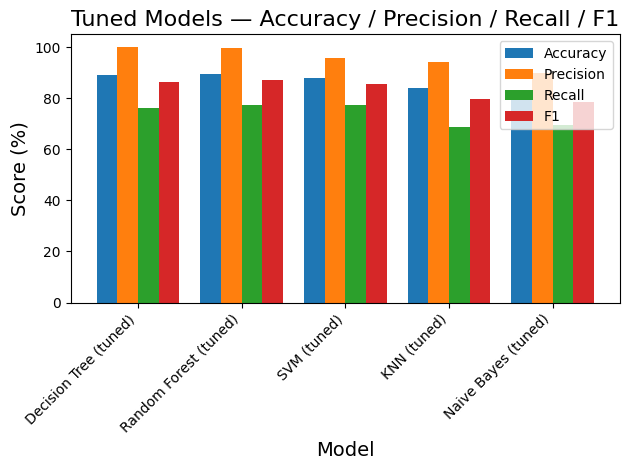

In [33]:
# Cell 26: Bar chart for tuned models

plt.figure(figsize=(14, 6))
metrics_df_tuned.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1']].plot(
    kind='bar',
    width=0.8
)
plt.title('Tuned Models — Accuracy / Precision / Recall / F1', fontsize=16)
plt.ylabel('Score (%)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


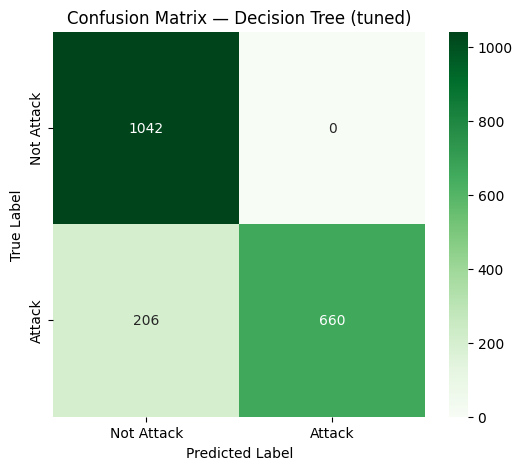

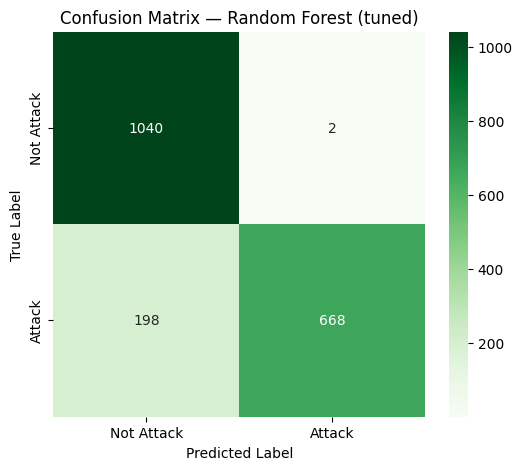

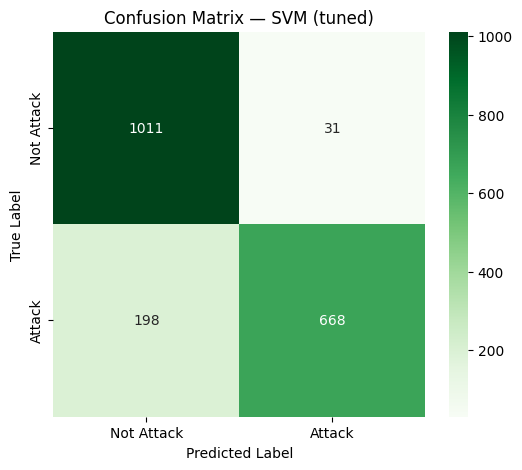

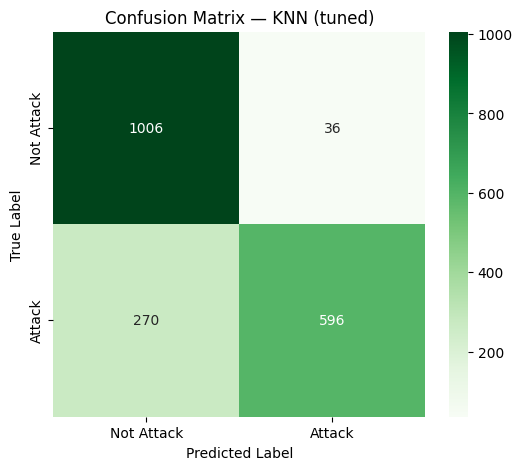

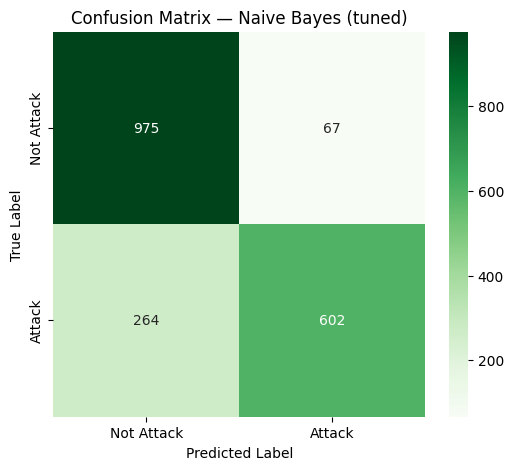

In [34]:
# Cell 27: Confusion matrices for tuned models

classes = ['Not Attack', 'Attack']

for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title(f'Confusion Matrix — {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Best tuned model by F1: Random Forest (tuned)
              precision    recall  f1-score   support

  Not Attack       0.84      1.00      0.91      1042
      Attack       1.00      0.77      0.87       866

    accuracy                           0.90      1908
   macro avg       0.92      0.88      0.89      1908
weighted avg       0.91      0.90      0.89      1908


Top 15 Features (Random Forest):


,0
failed_logins,0.301049
ip_reputation_score,0.239415
login_attempts,0.236780
session_duration,0.082015
network_packet_size,0.072552
browser_type_Unknown,0.030385
encryption_used_DES,0.007706
unusual_time_access,0.006283
browser_type_Firefox,0.006200
protocol_type_TCP,0.005554


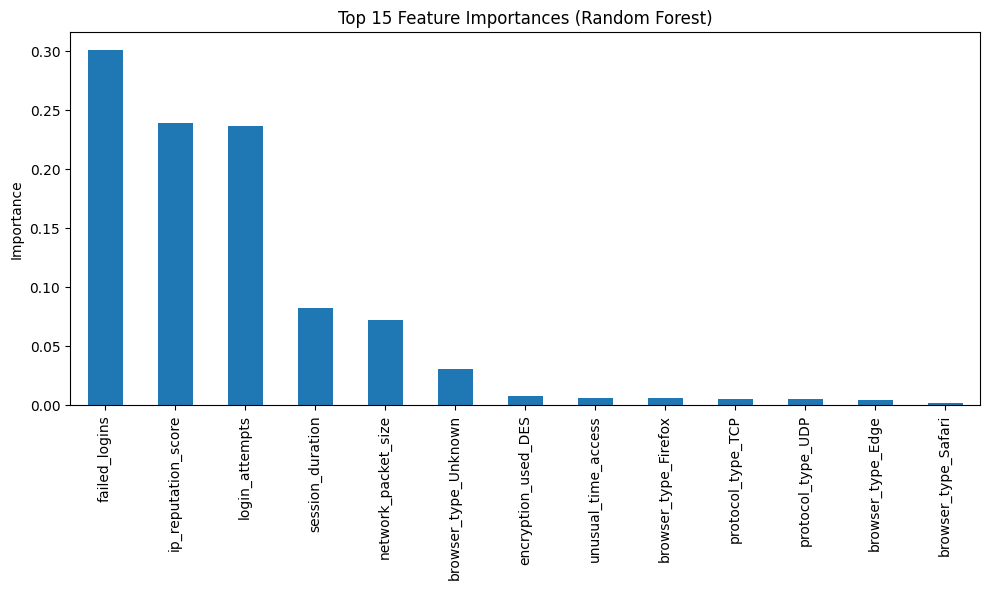

In [35]:
# Cell 28: Best tuned model report & RF feature

best_row = metrics_df_tuned.sort_values('F1', ascending=False).iloc[0]
best_name = best_row['Model']
best_pipeline = tuned_models[best_name]

print("Best tuned model by F1:", best_name)

y_pred_best = best_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_best, target_names=['Not Attack', 'Attack']))

# If Random Forest is best, show feature importances
if "Random Forest" in best_name:
    rf_clf = best_pipeline.named_steps['clf']
    importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)

    print("\nTop 15 Features (Random Forest):")
    display(importances.head(15))

    plt.figure(figsize=(10, 6))
    importances.head(15).plot(kind='bar')
    plt.title('Top 15 Feature Importances (Random Forest)')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()


In [36]:
# Cell 29: Threshold tuning example for tuned Random Forest

def tune_threshold(model, X_valid, y_valid, metric='f1'):
    if hasattr(model, 'predict_proba'):
        scores = model.predict_proba(X_valid)[:, 1]
    elif hasattr(model, 'decision_function'):
        scores = model.decision_function(X_valid)
    else:
        raise ValueError("Model has no probability or decision_function output.")

    best_t, best_val = 0.5, -1
    for t in np.linspace(0.1, 0.9, 81):
        y_hat = (scores >= t).astype(int)
        if metric == 'f1':
            val = f1_score(y_valid, y_hat)
        elif metric == 'recall':
            val = recall_score(y_valid, y_hat)
        elif metric == 'precision':
            val = precision_score(y_valid, y_hat)
        else:
            val = f1_score(y_valid, y_hat)
        if val > best_val:
            best_val, best_t = val, t
    return best_t, best_val

# use tuned Random Forest
best_rf.fit(X_train, y_train)
t_star, val = tune_threshold(best_rf, X_test, y_test, metric='f1')
print(f"RF tuned best threshold: {t_star:.2f} (best F1={val:.4f})")

rf_scores = best_rf.predict_proba(X_test)[:, 1]
y_hat_thresh = (rf_scores >= t_star).astype(int)

print("RF (thresholded) — Acc: {:.2f} | Prec: {:.2f} | Rec: {:.2f} | F1: {:.2f}".format(
    accuracy_score(y_test, y_hat_thresh)*100,
    precision_score(y_test, y_hat_thresh)*100,
    recall_score(y_test, y_hat_thresh)*100,
    f1_score(y_test, y_hat_thresh)*100
))


RF tuned best threshold: 0.42 (best F1=0.8729)
RF (thresholded) — Acc: 89.73 | Prec: 99.56 | Rec: 77.71 | F1: 87.29
